## Imports


In [3]:
import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 

import pathlib
import zipfile
import os
import random
import datetime

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andreasmavropoulos","key":"db7643534c5cc663e5b197cda0bbd531"}'}

In [5]:
# Check if you upload successful
!ls -lha kaggle.json
# Output: -rw-r--r-- 1 root root 63 Aug  8 11:17 kaggle.json

# Install kaggle package
!pip install -q kaggle

-rw-r--r-- 1 root root 74 Jan 17 17:57 kaggle.json


## Make kaggle directory and download dataset

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Start to download dataset
!kaggle datasets download -d prasunroy/natural-images

 96% 329M/342M [00:02<00:00, 110MB/s] 
100% 342M/342M [00:02<00:00, 127MB/s]


## Unzip and view dataset

In [8]:
zip_ref = zipfile.ZipFile("natural-images.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# How many images in each folder
for dirpath,dirnames,filenames in os.walk('/content/natural_images'):
  if len(dirnames) == 0:
    print(f"There are {len(filenames)} images in {dirpath} ")
  else:
    print(f"There are {len(dirnames)} directories in {dirpath}")

In [10]:
# Get the subdirectories (class_names)
data_dir = pathlib.Path('/content/natural_images')
class_names = np.array(sorted(item.name for item in data_dir.glob("*")))
print(class_names)

['airplane' 'car' 'cat' 'dog' 'flower' 'fruit' 'motorbike' 'person']


## Functions

In [11]:
# Make a function to view random images for each class
def view_images(target_dir):
  """
  Plots out a random image for each class
  """
  plt.figure(figsize=(15,15))
  for i in range(len(class_names)):
    plt.subplot(4,4,i+1)
    target_folder = target_dir + "/" + class_names[i]
    random_image = random.sample(os.listdir(target_folder),1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.axis("off")
    img_info = class_names[i] + "\n" + str(img.shape)
    plt.title(img_info)

In [12]:
def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%d-%m-%Y|%H:%M")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"Saving Tensorboard experiment log files to : {log_dir}")
  return tensorboard_callback

In [13]:
# Lets make a function to create a model from url
def create_model(model_url,num_classes = len(class_names)):
  """
  Creates a keras model from a tf hub url

  Returns:
    An uncompiled Keras sequential model
  """
  # Download the pretained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = "feature_extractor_layer",
                                           input_shape = IMAGE_SHAPE + (3,))
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes,activation="softmax",name="Output_layer")
  ])
  return model

In [14]:
# Function to view loss and accuracy of a model
def plot_loss_curves(history):
  """
  Plots out separate loss curves for training and validation data
  """
  loss = history.history["loss"]
  accuracy = history.history["accuracy"]
  epochs = range(len(history.history["loss"]))

  # Plot the loss
  plt.plot(epochs,loss,label="training loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot out the accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="Training accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

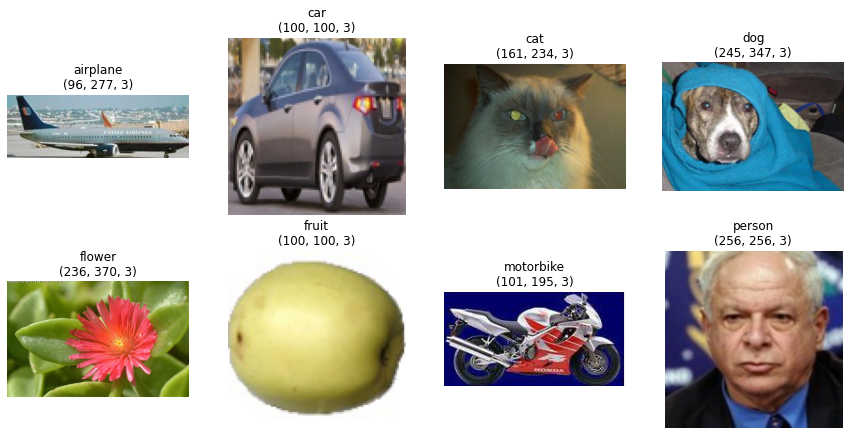

In [15]:
view_images("/content/natural_images")

## Setting up data for the model training

In [16]:
# Setup global variables
IMAGE_SHAPE = (512,512)
BATCH_SIZE = 32
EPOCHS = 2

train_dir = "/content/natural_images"

train_datagen = ImageDataGenerator(rescale = 1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = IMAGE_SHAPE,
                                               batch_size = BATCH_SIZE,
                                               class_mode = "categorical")

Found 6899 images belonging to 8 classes.


In [17]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1"

In [18]:
# Create model
efficientnet_model = create_model(model_url = efficientnet_url)

# Compile the model
efficientnet_model.compile(loss = "categorical_crossentropy",
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ["accuracy"])

In [19]:
efficient_history = efficientnet_model.fit(train_data,
                                           epochs = EPOCHS,
                                           steps_per_epoch = len(train_data),
                                           callbacks = [create_tensorboard_callback(dir_name= "Tf_hub_models",
                                                                                    experiment_name = "efficientnetB7V1")])

Saving Tensorboard experiment log files to : Tf_hub_models/efficientnetB7V1/17-01-2022|17:58
Epoch 1/2
216/216 [==============================] - 434s 2s/step - loss: 0.1710 - accuracy: 0.9826
Epoch 2/2
216/216 [==============================] - 395s 2s/step - loss: 0.0165 - accuracy: 0.9988


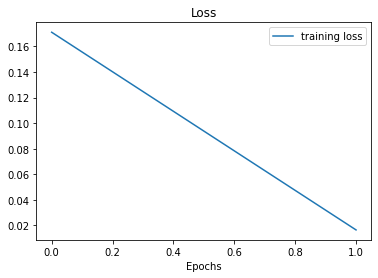

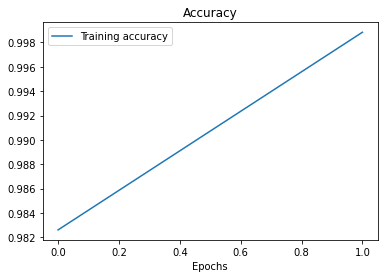

In [20]:
plot_loss_curves(efficient_history)

In [21]:
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2560)             64097680  
 rasLayer)                                                       
                                                                 
 Output_layer (Dense)        (None, 8)                 20488     
                                                                 
Total params: 64,118,168
Trainable params: 20,488
Non-trainable params: 64,097,680
_________________________________________________________________


## Time to test our model on some new unseen data

First lets create some functions to help us out

In [58]:
def load_and_prep_image(filename,image_shape = 512,scale = True):
  """
  Reads an image from a filename and turns it into a tensor 
  Reshapes the image into 224 by default
  Rescales the image into 0 and 1 by default
  """
  # Read the image 
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img , [image_shape,image_shape])
  img = img/255.
  return img

In [75]:
def pred_and_plot(model,file_path,class_names):
  """
  Predicts and plots customs images from a directory
  """
  # Setup figure size
  plt.figure(figsize=(20,20))
  # Get all the filenames under the file path
  filenames = os.listdir(file_path)

  # Get the image from the file path
  for i in range(len(filenames)):
    img = load_and_prep_image(file_path + "/" + filenames[i])
    # Make a prediction using the model on the img
    pred = model.predict(tf.expand_dims(img,axis=0))
      
    # Get the predicted class
    if len(pred[0] > 1): # Check for multi class labels
      pred_class = class_names[pred.argmax()] # If more than 2 labels take the max
    else:
      pred_class = class_names[int(tf.round(pred[0][0]))] # If only one output round them

    # Plot out the image
    plt.subplot(5,5,i + 1)
    plt.imshow(img)
    plt.title(f"Prediction: \n {pred_class}")
    plt.axis("off")

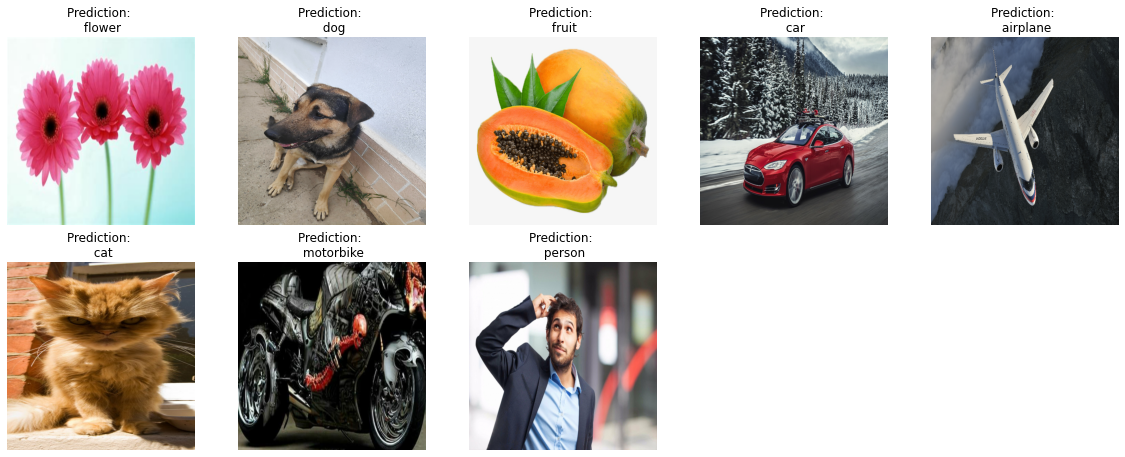

In [76]:
pred_and_plot(model = efficientnet_model,
              file_path = '/content/drive/MyDrive/machine_learning/natural_images',
              class_names = class_names)